In [2]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text as skl_text
import sklearn.model_selection as skl_ms
import sklearn.svm as skl_svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import sklearn.ensemble as skl_ensemble
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import joblib
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay


gradient_boost = joblib.load('/content/drive/MyDrive/data/gradient_boost_model.joblib')

svm = joblib.load('/content/drive/MyDrive/data/svm_trained_model.joblib')
forest_model = joblib.load('/content/drive/MyDrive/data/forest_trained_model.joblib')
logistic_model = joblib.load('/content/drive/MyDrive/data/logistic_trained_model.joblib')
vectorizer = joblib.load('/content/drive/MyDrive/data/vectorizer7000_dropword.joblib')

df_toxic = pd.read_csv('/content/drive/MyDrive/data/toxic_data.csv')
df_normal = pd.read_csv('/content/drive/MyDrive/data/normal_data.csv')
test_data = df_test = pd.read_csv('/content/drive/MyDrive/data/small_data.csv')
df_toxic = df_toxic[:10000]
df_normal = df_normal[:10000]
df_toxic['text_split'] = df_toxic['comment_text'].str.split(' ')
df_normal['text_split'] = df_normal['comment_text'].str.split(' ')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-2-99ea99d6c4fb>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toxic['text_split'] = df_toxic['comment_text'].str.split(' ')


In [3]:
k_folds = 10

df_toxic['toxic'] = np.where(df_toxic['toxicity'] >= 0.5, 1, 0)
df_normal['toxic'] = np.where(df_normal['toxicity'] >= 0.5, 1, 0)
kf = KFold(n_splits=k_folds)
toxic_id = []
for i, (train_toxic_id, test_toxic_id) in enumerate(kf.split(df_toxic)):
  toxic_id.append([train_toxic_id, test_toxic_id])
normal_id = []
for i, (train_normal_id, test_normal_id) in enumerate(kf.split(df_normal)):
  normal_id.append([train_normal_id, test_normal_id])

X_test = []
X_train = []
y_test = []
y_train = []
y_test_r = []
y_train_r = []

for i in range(k_folds):
  df_train = pd.concat([df_toxic.iloc[toxic_id[i][0]], df_normal.iloc[normal_id[i][0]]])
  df_test = pd.concat([df_toxic.iloc[toxic_id[i][1]], df_normal.iloc[normal_id[i][1]]])
  X_test.append(vectorizer.transform(df_test['comment_text']))
  X_train.append(vectorizer.transform(df_train['comment_text']))
  y_test.append(df_test['toxic'])
  y_train.append(df_train['toxic'])
  y_test_r.append(df_test['toxicity'])
  y_train_r.append(df_train['toxicity'])

data_t = vectorizer.transform(test_data['comment_text'])
label_t = test_data['toxic']

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
def roc_check(model, name):
  results = []
  sum = 0
  learnCurveX = []
  learnCurveY = []
  from scipy.sparse import csr_matrix, vstack, hstack

  X_Train = []
  y_Train = []
  for i in range(k_folds):
    model.fit(X_train[i], y_train[i])
    y_prob = model.predict(X_test[i])
    y_pred = np.where(y_prob[:, 1] >= 0.5, 1, 0)
    # print(f"Accuracy: {np.mean(y_pred == y_test[i])}")
    results.append(np.mean(y_pred == y_test[i]))

    if i == 0:
      X_Train = X_test[i]
    else:
      X_Train = vstack([X_Train, X_test[i]])
    y_Train.extend(y_test[i])
    # print(X_Train)/
    # print(y_Train)
    model.fit(X_Train, y_Train)
    prediction = model.predict(data_t)
    learnCurveX.append((i+1)*X_test[0].shape[0])
    learnCurveY.append(np.mean(prediction == label_t))

  #roc plot
  predict_proba =  model.predict(data_t)
  prediction = predict_proba
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
  fpr, tpr, thresholds = roc_curve(label_t, predict_proba)
  roc_auc = auc(fpr, tpr)
  ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
  ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random guess')
  ax1.set_xlabel('False Positive Rate')
  ax1.set_ylabel('True Positive Rate')
  ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
  ax1.legend(loc='lower right')

  precision, recall, thresholds1 = precision_recall_curve(label_t, predict_proba)
  average_precision = average_precision_score(label_t, predict_proba)

  # Plot precision-recall curve
  # print((y_test[i] == 1).sum(), y_test[i].shape[0])
  random_guess = (label_t == 1).sum() / label_t.shape[0]
  ax2.plot(recall, precision, color='darkorange', lw=2, label= f'AP = {average_precision:.2f}')
  ax2.axhline(y = random_guess, color='navy', lw=2, linestyle='--', label = 'Random guess')
  ax2.set_xlabel('Recall')
  ax2.set_ylabel('Precision')
  ax2.set_title('Precision-Recall Curve')
  ax2.legend()
  plt.show()
  #confusion matrix plot
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  cm = confusion_matrix(prediction, label_t, labels=[0, 1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
  disp.plot(cmap='Blues', values_format='d', ax=axes[0])
  axes[0].set_title('Confusion Matrix')
  cm = cm.astype(float)
  for i in range(cm.shape[0]):
    cm[i] = cm[i] / cm[i].sum()
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
  disp.plot(cmap='Blues', values_format='.2f', ax=axes[1])
  axes[1].set_title('Normalize Confusion Matrix')
  plt.tight_layout()
  plt.show()

  #learning curve plot
  plt.plot(learnCurveX, learnCurveY, color='Red')
  plt.xlabel('Traning Size')
  plt.ylabel('Accuracy')
  plt.title('Learning Curve')
  plt.show()

  plt.bar([x for x in range(1, k_folds+1)], results, color='blue', alpha=0.7)
  plt.xlabel('Fold Number')
  plt.ylabel('Accuracy')
  plt.title(f'K-Fold Cross-Validation Results (K={k_folds})')
  plt.ylim(0, 1)  # Set the y-axis limit for accuracy (0 to 1)
  plt.show()
  print("Average Accuracy: ", np.mean(results))
  print("Variance: ", np.var(results))
  # joblib.dump(model, f'/content/drive/MyDrive/MLProject/{name}joblib')

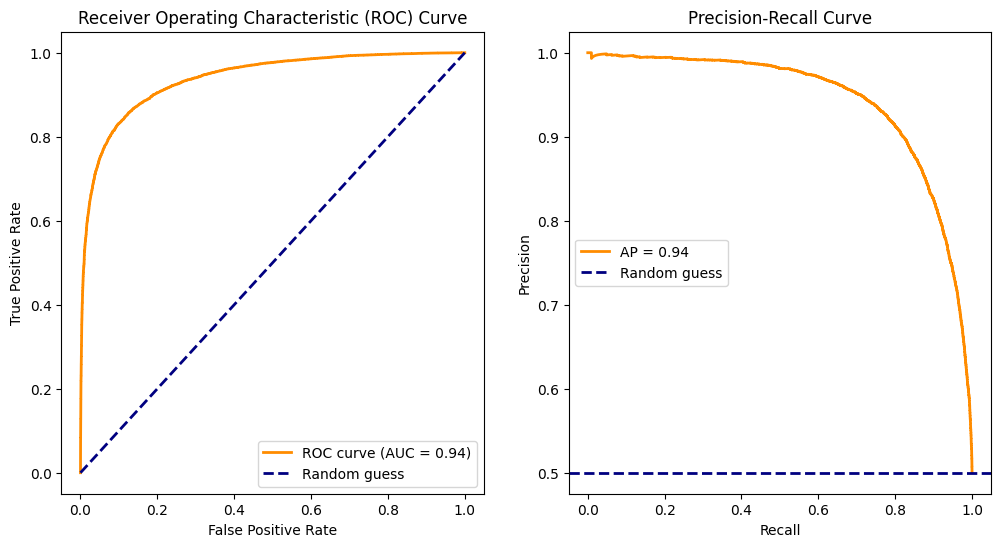

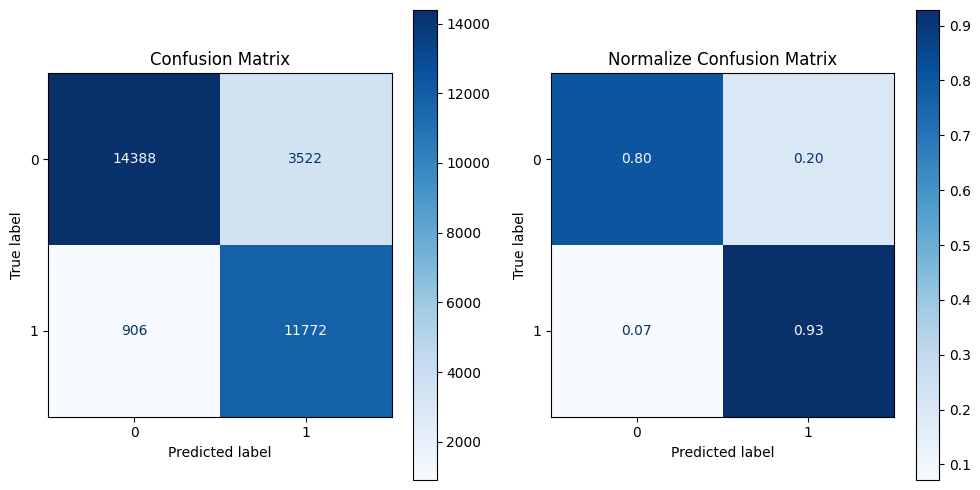

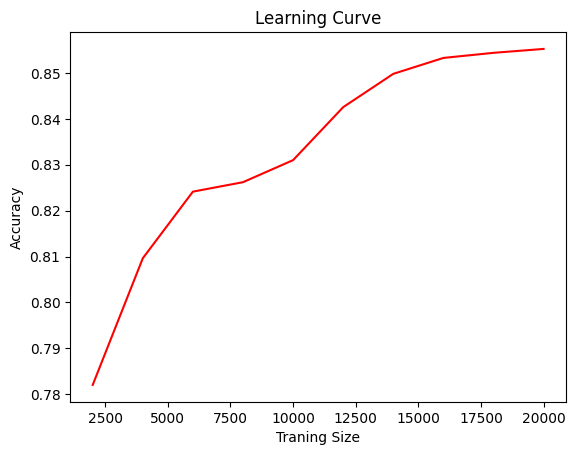

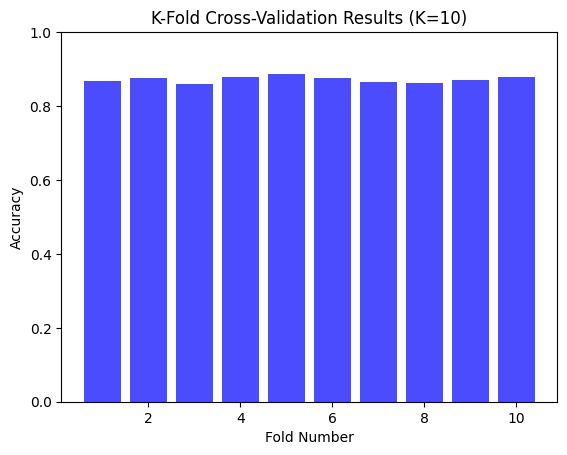

Average Accuracy:  0.8718999999999999
Variance:  6.723999999999958e-05


In [5]:
roc_check(logistic_model, "logistic_tfidf")

In [15]:
roc_check(skl_svm.SVR(), "svm_tfidf")

IndexError: ignored

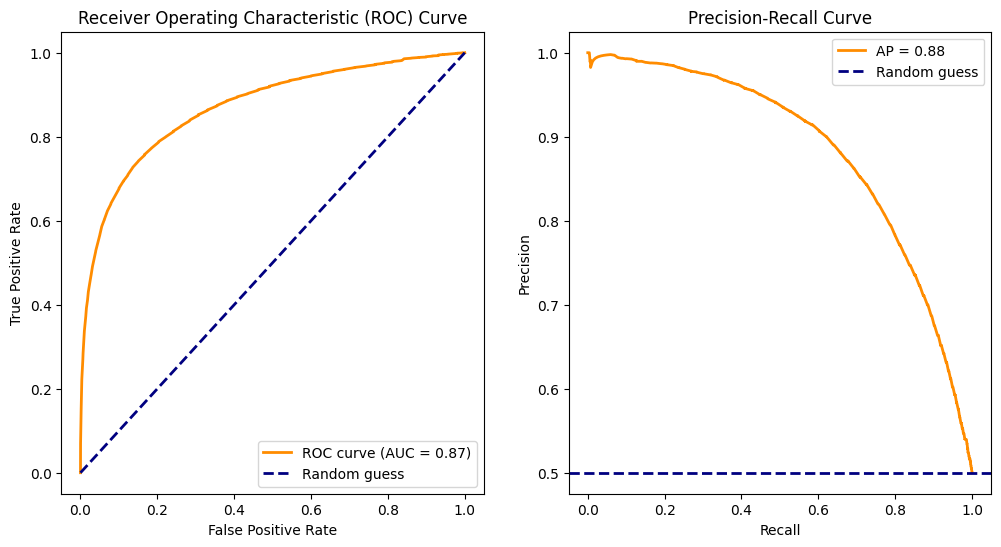

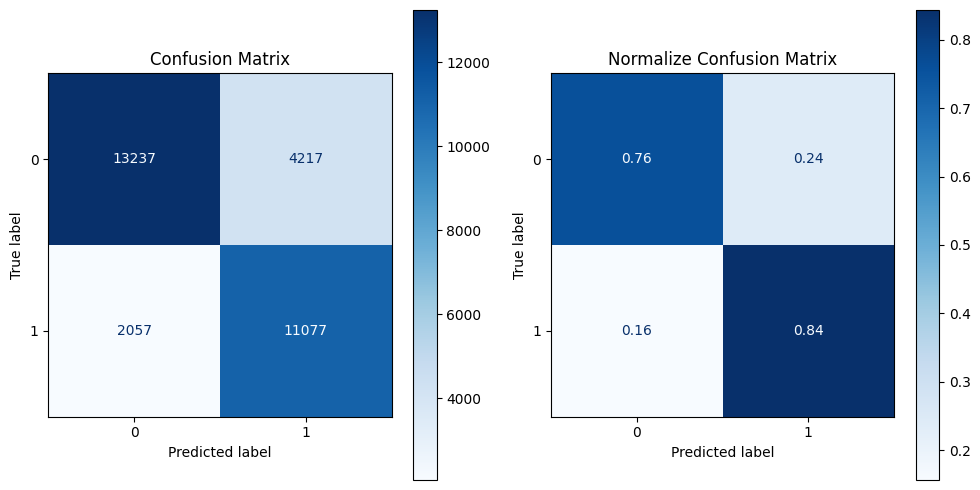

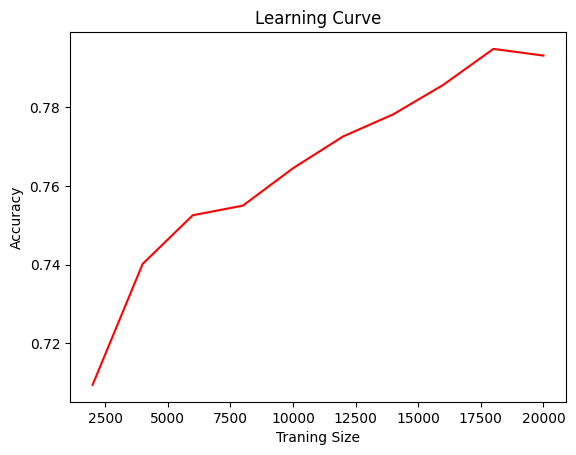

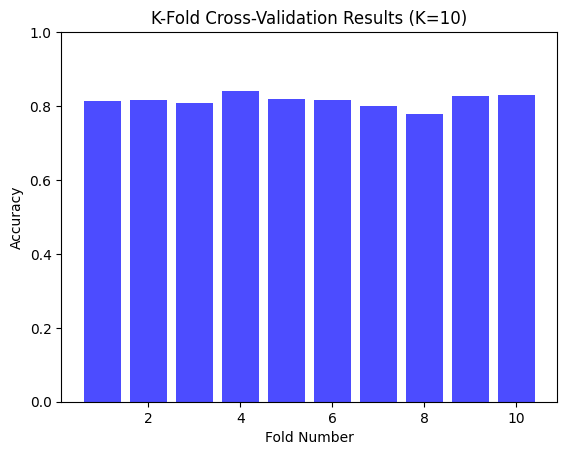

Average Accuracy:  0.81545
Variance:  0.0002691224999999995


In [8]:
roc_check(forest_model, "logistic_tfidf")